In [1]:
import utils
import models

import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm

import networkx as nx
import random

import time

from matplotlib import pyplot as plt
%matplotlib inline

from generate_graph import gen_graph
from generate_paths import gen_paths_agents


seed_n = 0
mult = 0

torch.manual_seed(seed_n)
np.random.seed(seed_n)
random.seed(seed_n)

In [2]:
from scipy.spatial.distance import jensenshannon

def compute_js_divergence(observed, predicted):
    observed_edge_usage = np.sum(observed, axis=0)
    predicted_edge_usage = np.sum(predicted, axis=0)
    
    observed_probabilities = observed_edge_usage / np.sum(observed_edge_usage)
    predicted_probabilities = predicted_edge_usage / np.sum(predicted_edge_usage)
    
    js_divergence = jensenshannon(observed_probabilities, predicted_probabilities)
    
    return js_divergence

from collections import Counter

def compute_js_divergence_paths(observed, predicted):
    # Convert paths to string representation for uniqueness
    observed_paths = [''.join(map(str, path)) for path in observed]
    predicted_paths = [''.join(map(str, path)) for path in predicted]
    
    # Count path frequencies
    observed_counter = Counter(observed_paths)
    predicted_counter = Counter(predicted_paths)
    
    # Get the top 10 most frequent paths in each set
    top_10_observed = set([path for path, _ in observed_counter.most_common(10)])
    top_10_predicted = set([path for path, _ in predicted_counter.most_common(10)])
    
    # Compute intersection and union
    intersection = top_10_observed.intersection(top_10_predicted)
    union = top_10_observed.union(top_10_predicted)
    
    # Compute IoU
    iou = len(intersection) / len(union) if len(union) > 0 else 0
    
    return iou

from scipy.stats import spearmanr
def rank_comparison(arr1, arr2):
    unique_rows_1, counts_1 = np.unique(arr1, axis=0, return_counts=True)
    unique_rows_2, counts_2 = np.unique(arr2, axis=0, return_counts=True)
    
    sorted_indices_1 = np.argsort(-counts_1)
    sorted_rows_1 = unique_rows_1[sorted_indices_1]
    sorted_counts_1 = counts_1[sorted_indices_1]
    
    sorted_indices_2 = np.argsort(-counts_2)
    sorted_rows_2 = unique_rows_2[sorted_indices_2]
    sorted_counts_2 = counts_2[sorted_indices_2]

    common_rows = set(map(tuple, sorted_rows_1)).intersection(set(map(tuple, sorted_rows_2)))
    
    if not common_rows:
        return 0  # No common rows to rank, correlation is zero
    
    rank_dict_1 = {tuple(row): rank for rank, row in enumerate(sorted_rows_1) if tuple(row) in common_rows}
    rank_dict_2 = {tuple(row): rank for rank, row in enumerate(sorted_rows_2) if tuple(row) in common_rows}
    
    ranks_1 = np.array([rank_dict_1[row] for row in common_rows])
    ranks_2 = np.array([rank_dict_2[row] for row in common_rows])
    
    correlation, _ = spearmanr(ranks_1, ranks_2)
    
    return correlation

In [3]:
n_paths, N_train, n_nodes, G, edges, points, distance_matrix, n_edges = gen_graph(seed_n)

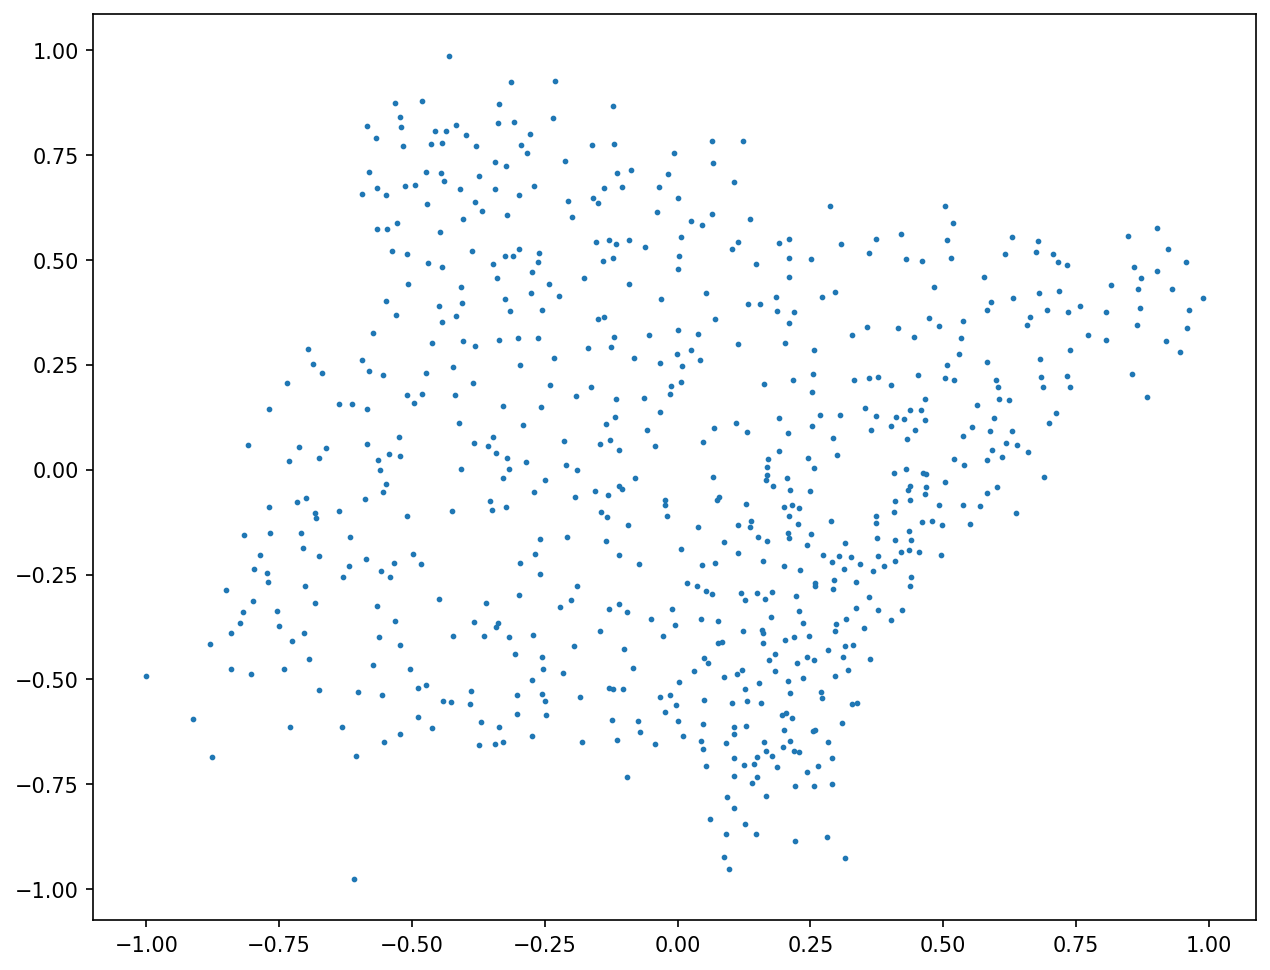

In [4]:
fig, ax = plt.subplots(figsize=(10,8), dpi=150)
plt.scatter(points[:,0], points[:,1], s=3)

In [5]:
X_train, X_test, n_paths_a1, n_paths_a2, n_paths_a3, agent_indicator, se_nodes, true_paths, reverse_ids_sort \
= gen_paths_agents(seed_n, n_paths, N_train, n_edges, distance_matrix, edges, n_nodes, points, mult)

100%|███████████████████████████████████████████████████████████| 6000/6000 [01:47<00:00, 55.79it/s]


Number of distinct paths: 246
Number of distinct paths 1: 73
Number of distinct paths 2: 96
Number of distinct paths 3: 77


In [6]:
solver = utils.Dijkstra(n_nodes, edges)

In [7]:
import models

In [8]:
eps = 0.05
lr = '4e-05'
BS=250
alpha_kl = 0.00001
seed_n = 0
latent_dim = 2
n_epochs=200

method = 'IOLVM'
mm = method + '_'
if method == 'IOLVM':
    mm = ''

suffix = f'{mm}{eps}_{lr}_{BS}_{alpha_kl}_{seed_n}_{latent_dim}_{n_epochs}_{mult}'

#suffix = f'{mm}{eps}_{lr}_{BS}_{alpha_kl}_{seed_n}_{latent_dim}_{n_epochs}_spear_iolvms_mults'
#suffix = f'{mm}{eps}_{lr}_{BS}_{alpha_kl}_{seed_n}_{latent_dim}_{n_epochs}'

In [9]:
output_path = f'./outputs/'
model_path = f'./saved_models/'

In [10]:
#centroids = np.load(f'./outputs/centroids_{suffix}.npy')
agents = np.load(f'./outputs/agents_{suffix}.npy')

loss = np.load(f'./outputs/loss_{suffix}.npy')
iou = np.load(f'./outputs/iou_{suffix}.npy')

latent_vectors = np.load(f'./outputs/latent_vector_{suffix}.npy')

In [11]:
encoder = models.Encoder(input_size=n_edges + 4, output_size=latent_dim, hl_sizes=[1000, 1000])  
encoder.load_state_dict(torch.load(f'{model_path}encoder_{suffix}.pkl'))
encoder.eval()

decoder = models.ANN(input_size=latent_dim, output_size=n_edges, hl_sizes=[1000, 1000])  
if method == 'VAE':
    decoder = models.ANN2(input_size=latent_dim, output_size=n_edges, hl_sizes=[1000, 1000])  
decoder.load_state_dict(torch.load(f'{model_path}decoder_{suffix}.pkl'))
decoder.eval()

ANN(
  (act1): ReLU()
  (linear1): Linear(in_features=2, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=1000, bias=True)
  (linear3): Linear(in_features=1000, out_features=1000, bias=True)
  (linear3A): Linear(in_features=1000, out_features=1000, bias=True)
  (linear4): Linear(in_features=1000, out_features=7230, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

/tmp/ipykernel_128127/1180751410.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


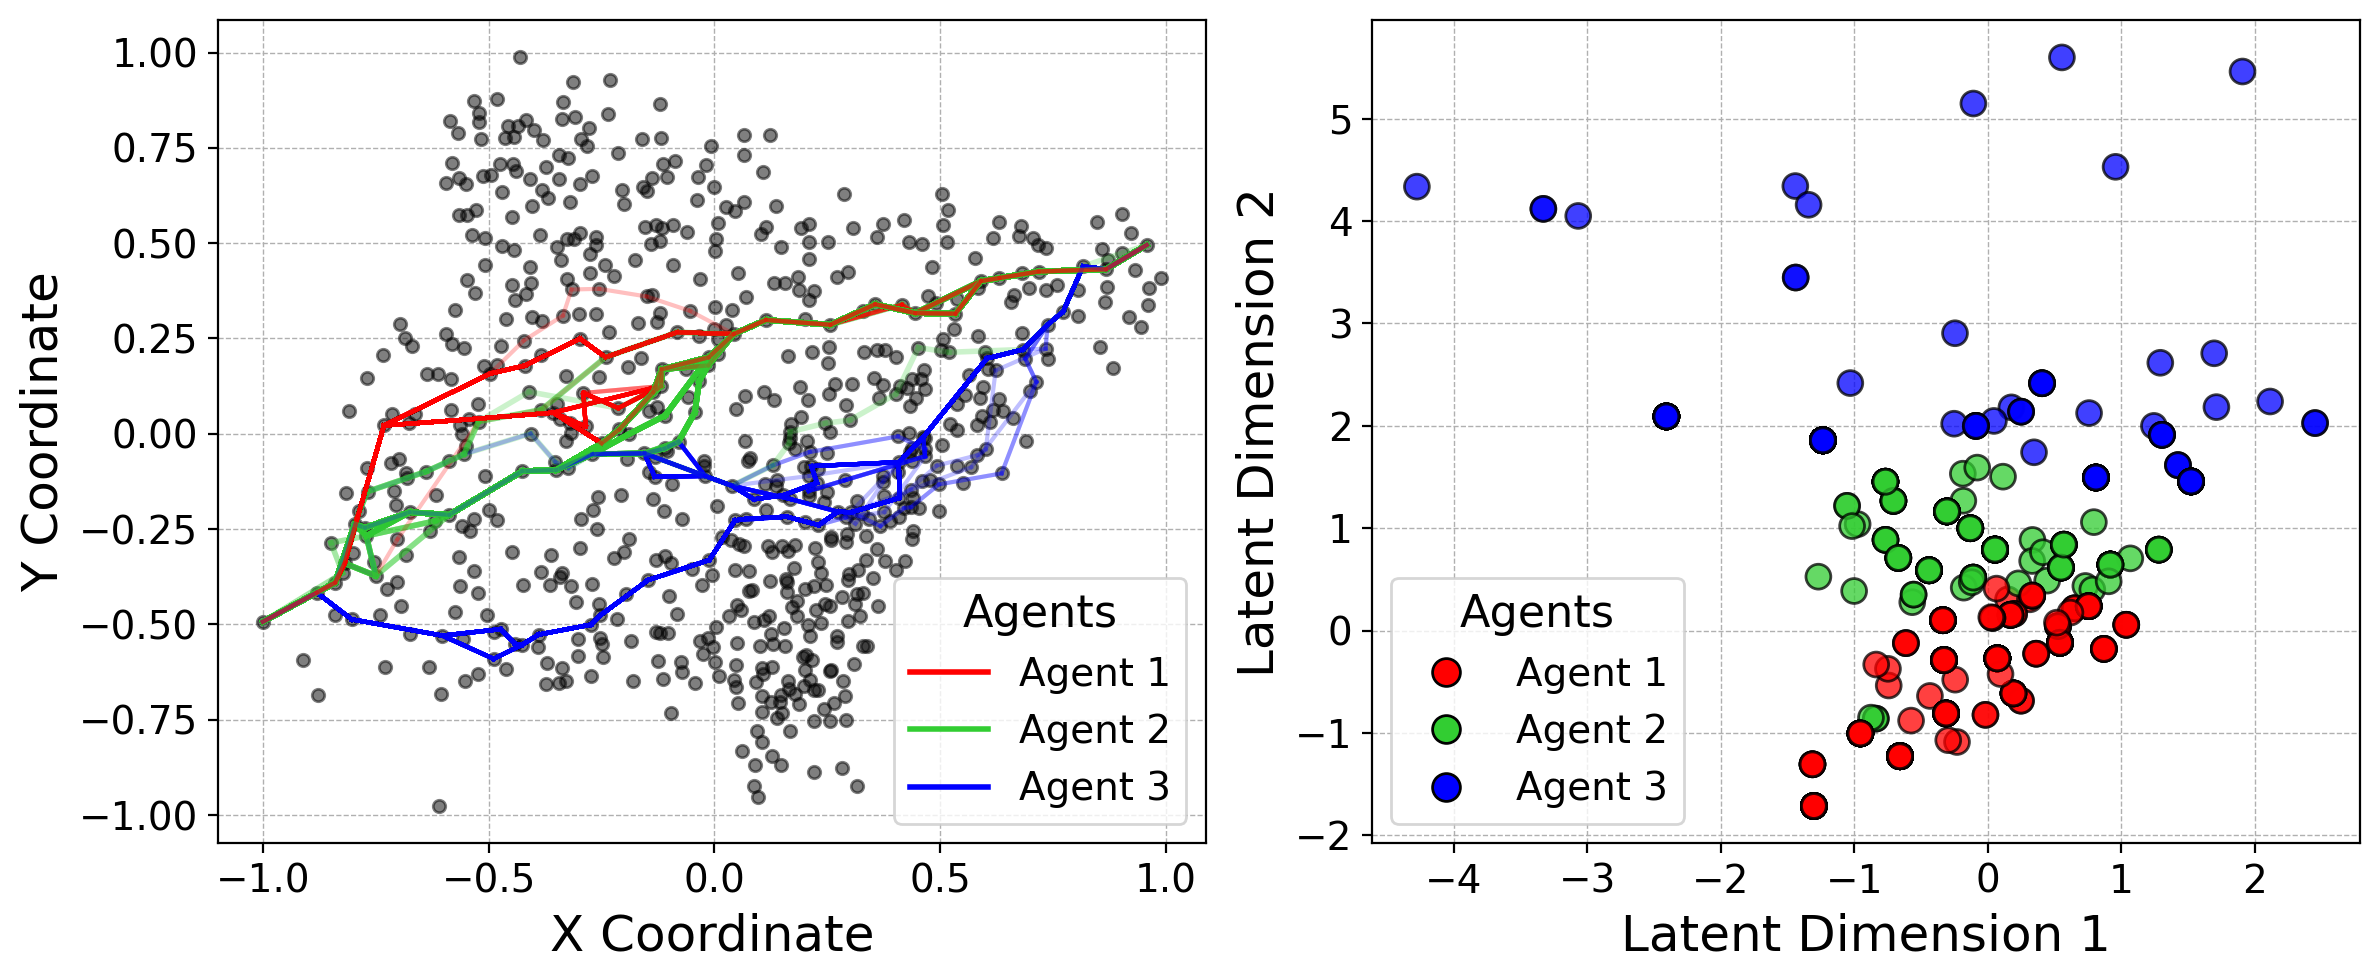

In [12]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

# Set up figure and axes for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# ------------------------ First Plot: Paths for Each Agent ------------------------

# Plot paths for each agent on the first subplot
ax = axs[0]
for i in range(1000):
    ee = edges[np.argwhere(true_paths[i] > 0).squeeze()]
    for line in points[ee]:
        x_values = [line[0, 0], line[1, 0]]
        y_values = [line[0, 1], line[1, 1]]
        if agent_indicator[i] == 1:
            color = 'red'
            lw = 1.5
        elif agent_indicator[i] == 2:
            color = 'limegreen'
            lw = 2
        elif agent_indicator[i] == 3:
            color = 'blue'
            lw = 1.5
        ax.plot(x_values, y_values, color=color, alpha=0.25, linewidth=lw)

# Scatter plot for graph nodes
ax.scatter(points[:, 0], points[:, 1], s=20, color='black', alpha=0.5)

# Axis labels and title with larger fonts
ax.set_xlabel('X Coordinate', fontsize=18)
ax.set_ylabel('Y Coordinate', fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Custom legend for the first plot
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Agent 1'),
                   Line2D([0], [0], color='limegreen', lw=2, label='Agent 2'),
                   Line2D([0], [0], color='blue', lw=2, label='Agent 3')]
ax.legend(handles=legend_elements, fontsize=14, title='Agents', title_fontsize=16)

# Improve layout and appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# ----------------------- Second Plot: Latent Vectors Scatter -----------------------

# Scatter plot of latent vectors on the second subplot
ax = axs[1]

# Latent vectors and agent mapping
lats = latent_vectors[-1]
color_map = {1: 'red', 2: 'limegreen', 3: 'blue'}
colors = np.array([color_map[agent] for agent in agents])

# Scatter plot
scatter = ax.scatter(lats[:, 0], lats[:, 1], c=colors, s=80, edgecolor='k', alpha=0.75)

# Add labels with larger font sizes
ax.set_xlabel('Latent Dimension 1', fontsize=18)
ax.set_ylabel('Latent Dimension 2', fontsize=18)

# Custom legend for the second plot
legend_labels = {1: 'Agent 1', 2: 'Agent 2', 3: 'Agent 3'}
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10, markeredgecolor='k') 
           for key in legend_labels.keys()]
ax.legend(handles, [legend_labels[key] for key in legend_labels.keys()], title='Agents', fontsize=14, title_fontsize=16)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Improve layout and appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# ----------------------- Save and Display the Combined Figure -----------------------

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the combined figure
plt.savefig('./imgs_paper/combined_agent_paths_and_latent_vectors_mult.png', format='png', dpi=200)

# Display the combined plot
plt.show()

In [13]:
agents.shape

(1000,)

In [14]:
N_test = 1000

sn_points = points[se_nodes[:,0]]
en_points = points[se_nodes[:,1]]
    
sn_train_torch = torch.tensor(sn_points, dtype=torch.float32)
en_train_torch = torch.tensor(en_points, dtype=torch.float32)
se_points_torch = torch.hstack((sn_train_torch, en_train_torch))

        
input_encoder = torch.hstack((torch.tensor(true_paths, dtype=torch.float32), se_points_torch))

z_mu, z_logvar, z_sample = encoder(input_encoder)
z_mu_np = z_mu.detach().numpy()

edges_to_eval = decoder(torch.tensor(z_mu, dtype=torch.float32))

/tmp/ipykernel_128127/356805812.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_to_eval = decoder(torch.tensor(z_mu, dtype=torch.float32))


In [15]:
edg1val = ((edges_to_eval[:1000][agents==1].mean(0) - edges_to_eval.mean(0))/edges_to_eval.std(0)).detach().numpy()
edg2val = ((edges_to_eval[:1000][agents==2].mean(0) - edges_to_eval.mean(0))/edges_to_eval.std(0)).detach().numpy()
edg3val = ((edges_to_eval[:1000][agents==3].mean(0) - edges_to_eval.mean(0))/edges_to_eval.std(0)).detach().numpy()
edg_val_norm = ((edges_to_eval[:1000] - edges_to_eval.mean(0))/edges_to_eval.std(0)).detach().numpy()

#edg1val = edges_to_eval[:1000][agents==1].mean(0).detach().numpy()
#edg2val = edges_to_eval[:1000][agents==2].mean(0).detach().numpy()
#edg3val = edges_to_eval[:1000][agents==3].mean(0).detach().numpy()

In [16]:
edges_to_eval.std(0)

tensor([0.0499, 0.0590, 0.0152,  ..., 0.0461, 0.0146, 0.0293],
       grad_fn=<StdBackward0>)

/tmp/ipykernel_128127/1816150628.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = get_cmap('PiYG_r')


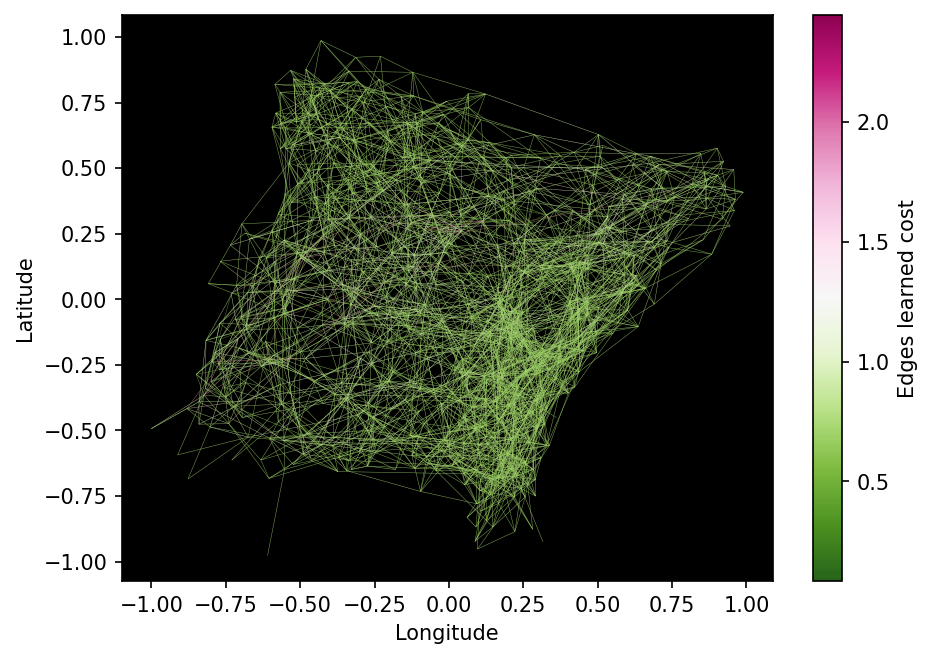

In [17]:
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize

segments = [(points[edges[i]][0], points[edges[i]][1]) for i in range(len(edges))]

cmap_reversed = get_cmap('PiYG_r')
norm = Normalize(vmin=np.quantile(edges_to_eval[:1000].mean(0).detach().numpy(), 0.001), 
                 vmax=np.quantile(edges_to_eval[:1000].mean(0).detach().numpy(), 0.999))
lc = LineCollection(segments, cmap=cmap_reversed, norm=norm, linewidth=0.2, alpha=0.5)



lc.set_array(edges_to_eval[:1000][agents==3].mean(0).detach().numpy())

#lc_high = LineCollection(segments_high, color='red', norm=norm, linewidth=0.5, alpha=0.3)
#lc_high.set_array(val_diff_edge)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
ax.add_collection(lc)
#ax.add_collection(lc_high)
ax.autoscale()

ax.set_facecolor((0.0, 0.0, 0.0))


cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap_reversed), ax=ax)
cbar.set_label('Edges learned cost')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [24]:
from collections import Counter
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
solver = utils.Dijkstra(n_nodes, edges)
ids_to_test = np.arange(N_train,N_train+N_test)
n_to_eval = N_test

In [27]:
euc_costs = distance_matrix[edges[:,0], edges[:,1]]
path_gen_euc = np.array(solver.batched_solver(np.expand_dims(euc_costs, 0), se_nodes[ids_to_test]))
path_tr = true_paths[ids_to_test]
js_euc_mult = compute_js_divergence(path_gen_euc, path_tr)
spear_euc_mult = np.sqrt(((path_gen_euc.mean(0) - path_tr.mean(0))**2).sum())

In [28]:
js_euc_mult

0.8036244130761788

In [29]:
spear_euc_mult

4.195913607308902

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.011135286474056602]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04443312194524773]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.031261361868823695]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.011914040471716063]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning

Best score=3.8259
Best parameters= [0.011914040471716063]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.015728755092189142]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04714094643366812]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03840770737337406]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.024956619438571144]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

Best score=4.1087
Best parameters= [0.005000740553620986]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03588521019661554]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.01636337554838182]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04062131779729728]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03243522352347756]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: T

Best score=3.6940
Best parameters= [0.01719802487671766]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.023283437403027823]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04312022584821754]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.006969814476958582]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.0409450830714195]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: 

Best score=3.0659
Best parameters= [0.019916678335958293]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005000048972467152] before, using random point [0.02145679193084913]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0050025509706257566] before, using random point [0.048564461108641654]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0050044695652244845] before, using random point [0.014387546833358723]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0050000053386061675] before, using random point [0.006312357561346199]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python

Best score=3.8616
Best parameters= [0.01562968281164572]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.02521251314097235]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.02340270503407982]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.011858832542380706]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.006554911933648974]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

Best score=3.4403
Best parameters= [0.034177865861965535]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03213077973854776]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04513584545685869]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.02874925208553635]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.017537197527142688]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: 

Best score=3.9370
Best parameters= [0.04513584545685869]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.015463773269290968]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.01804920691656967]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.023990908751910296]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.008211864353374823]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning

Best score=3.6894
Best parameters= [0.01902419135388656]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.032279237655450814]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.048080060548323096]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03727404476503839]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03456376470432041]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

Best score=3.3199
Best parameters= [0.03530288848199761]


/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.04663832115798269]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.045818757968512924]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.03166325191618347]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.005] before, using random point [0.024433484525095046]
  warnings.warn(
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

Best score=3.8403
Best parameters= [0.013539495659700387]


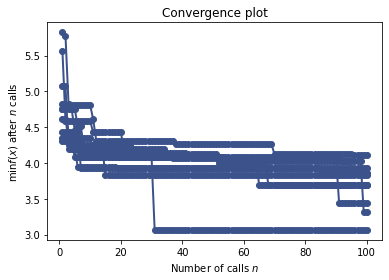

In [62]:
from skopt import gp_minimize
from skopt.plots import plot_convergence

def black_box_function(x):
    path_gen_bo = np.array(solver.batched_solver(np.expand_dims(np.clip(euc_costs + x[0]*np.random.randn(euc_costs.shape[0]), 0.0001, 10), 0), se_nodes[ids_to_test]))
    err = np.sqrt(((path_gen_bo.mean(0) - path_tr.mean(0))**2).sum())
    return err

rmse_bo = []
js_bo = []

for i in range(10):
    result = gp_minimize(
        func=black_box_function,     
        dimensions=[(0.005, 0.05)],    
        acq_func="EI",               
        n_calls=100,                 
        random_state=i
    )
    
    print("Best score=%.4f" % result.fun)
    print("Best parameters=", result.x)
    
    plot_convergence(result)
    
    path_gen_bo = np.array(solver.batched_solver(np.expand_dims(np.clip(euc_costs + result.x[0]*np.random.randn(euc_costs.shape[0]), 0.0001, 10), 0), se_nodes[ids_to_test])) 
    
    rmse_bo.append(result.fun)
    js_bo.append(compute_js_divergence(path_gen_bo, path_tr))

In [63]:
np.array(rmse_bo).mean(), np.array(rmse_bo).std()

(3.6782958529053134, 0.29904952516191924)

In [64]:
np.array(js_bo).mean(), np.array(js_bo).std()

(0.7770904111970361, 0.040417188946135156)

In [96]:
n_runs = 10
js_po_mults = np.zeros((n_runs,))
spear_po_mults = np.zeros((n_runs,))
for i in tqdm(range(0, n_runs)):
    z_mu_mean = np.expand_dims(np.quantile(z_mu_np, 0.5, 0), 1).repeat(n_to_eval,1).T
    edges_to_eval = decoder(torch.ones((N_test,latent_dim), dtype=torch.float32))
    edges_to_eval = (edges_to_eval + 0.05*torch.randn_like(edges_to_eval)).clip(0.0001)
    path_gen = np.array(solver.batched_solver(edges_to_eval.detach().numpy(), se_nodes[ids_to_test]))
    path_tr = true_paths[ids_to_test]
    js_po_mult = compute_js_divergence(path_gen, path_tr)
    spear_po_mult = np.sqrt(((path_gen.mean(0) - path_tr.mean(0))**2).sum())
    js_po_mults[i] = js_po_mult
    spear_po_mults[i] = spear_po_mult

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.96s/it]


In [74]:
n_runs = 10
js_po_mults = np.zeros((n_runs,))
spear_po_mults = np.zeros((n_runs,))
for i in tqdm(range(0, n_runs)):
    z_mu_mean = np.expand_dims(np.quantile(z_mu_np, 0.5, 0), 1).repeat(n_to_eval,1).T
    edges_to_eval = decoder(torch.tensor(z_mu_mean, dtype=torch.float32))
    edges_to_eval = (edges_to_eval + 0.05*torch.randn_like(edges_to_eval)).clip(0.0001)
    path_gen = np.array(solver.batched_solver(edges_to_eval.detach().numpy(), se_nodes[ids_to_test]))
    path_tr = true_paths[ids_to_test]
    js_po_mult = compute_js_divergence(path_gen, path_tr)
    spear_po_mult = np.sqrt(((path_gen.mean(0) - path_tr.mean(0))**2).sum())
    js_po_mults[i] = js_po_mult
    spear_po_mults[i] = spear_po_mult

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.60s/it]


In [97]:
js_po_mults.mean(), js_po_mults.std()

(0.057366922383456684, 0.007436479260633118)

In [99]:
spear_po_mults.mean(), spear_po_mults.std()

(0.21867325052282052, 0.062826821547678)

In [104]:
from scipy.stats import t

mean1, std1, n1 = 0.177, 0.067, 20
mean2, std2, n2 = 0.151, 0.034, 20

# Welch’s t-statistic
se1 = std1**2 / n1
se2 = std2**2 / n2
t_stat = (mean1 - mean2) / np.sqrt(se1 + se2)

# Degrees of freedom
df = (se1 + se2)**2 / ((se1**2 / (n1 - 1)) + (se2**2 / (n2 - 1)))

# Two-tailed p-value
p_value = 2 * t.sf(np.abs(t_stat), df)
print("p-value:", p_value)

p-value: 0.13288010668193367


In [55]:
n_runs = 10
js_iolvms_mults = np.zeros((n_runs,))
spear_iolvms_mults = np.zeros((n_runs,))
for i in range(0, n_runs):
    ids_to_fit_kde = np.random.randint(0, len(z_mu_np), 5000)
    kde.fit(z_mu_np[ids_to_fit_kde])
    z_samples = kde.sample(n_to_eval)
    if method == 'VAE':
        path_gen = torch.where(decoder(torch.tensor(z_samples, dtype=torch.float32))>=0., 1., 0.).detach().numpy()   
    else:
        edges_to_eval = decoder(torch.tensor(z_samples, dtype=torch.float32))
        path_gen = np.array(solver.batched_solver(edges_to_eval.detach().numpy(), se_nodes[ids_to_test]))
    path_tr = true_paths[ids_to_test]
    js_iolvm = compute_js_divergence(path_gen, path_tr)
    spear_iolvm_mult = np.sqrt(((path_gen.mean(0) - path_tr.mean(0))**2).sum())
    js_iolvms_mults[i] = js_iolvm
    spear_iolvms_mults[i] = spear_iolvm_mult

In [58]:
js_iolvms_mults.mean(), js_iolvms_mults.std()

(0.05393784533858985, 0.0030781778026003886)

In [59]:
spear_iolvms_mults.mean(), spear_iolvms_mults.std()

(0.15078670031111524, 0.0341668115176983)

In [ ]:
VAE
0.05951629469968596
0.17720493297837903

In [27]:
se_nodes_test = np.repeat(np.array([[124, 484]]), N_test, axis=0)# Plot the latent space points (replace this with your actual latent vectors)
latent_points = latent_vectors[-1]  # Assuming latent_vectors is defined
ax.scatter(latent_points[:, 0], latent_points[:, 1], color='red', s=10, label="Latent Space Points", alpha=0.6)

In [22]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.01)

In [23]:
n_to_evals = 5
result_js = np.zeros((n_to_evals))
result_js_path = np.zeros((n_to_evals))
result_rank = np.zeros((n_to_evals))
for k in range(0,n_to_evals):
    kde.fit(z_mu.detach())
    samples = kde.sample(N_test)
    edges_to_eval, _, _ = decoder(torch.tensor(samples, dtype=torch.float32))
    if method == 'IOLVM':
        path_gen = np.array(solver.batched_solver(edges_to_eval.detach(), se_nodes_test))
    elif method == 'VAE':
        path_gen = np.where(edges_to_eval.detach().numpy()<0.5, 0, 1).astype(int)
    result_js[k] = compute_js_divergence(true_paths[-1000:], path_gen)
    result_js_path[k] = compute_js_divergence_paths(true_paths[-1000:].astype(int), path_gen)
    result_rank[k] = rank_comparison(true_paths[-1000:].astype(int), path_gen)

ValueError: too many values to unpack (expected 3)

In [21]:
(result_js.mean(), result_js.std())

(0.13997107420092716, 0.0007527754740055508)

In [22]:
(result_js_path.mean(), result_js_path.std())

(0.5230769230769231, 0.03076923076923075)

In [23]:
(result_rank.mean(), result_rank.std())

(0.5239393939393938, 0.16410818622494805)

In [24]:
rank_corr = rank_comparison(true_paths[-1000:].astype(int), path_gen)

In [25]:
np.unique(path_gen, axis=0).shape

(10, 7230)

In [26]:
n_to_evals = 5
result_js = np.zeros((n_to_evals))
for k in range(0,n_to_evals):
    idcs = torch.randint(0,N_train, (N_test,))
    edges_to_eval, _, _ = decoder(z_mu[idcs] + 0.05*torch.randn_like(z_mu[idcs]))
    path_gen = np.array(solver.batched_solver(edges_to_eval.detach(), se_nodes_test))
    result_js[k] = compute_js_divergence(true_paths[-1000:], path_gen)

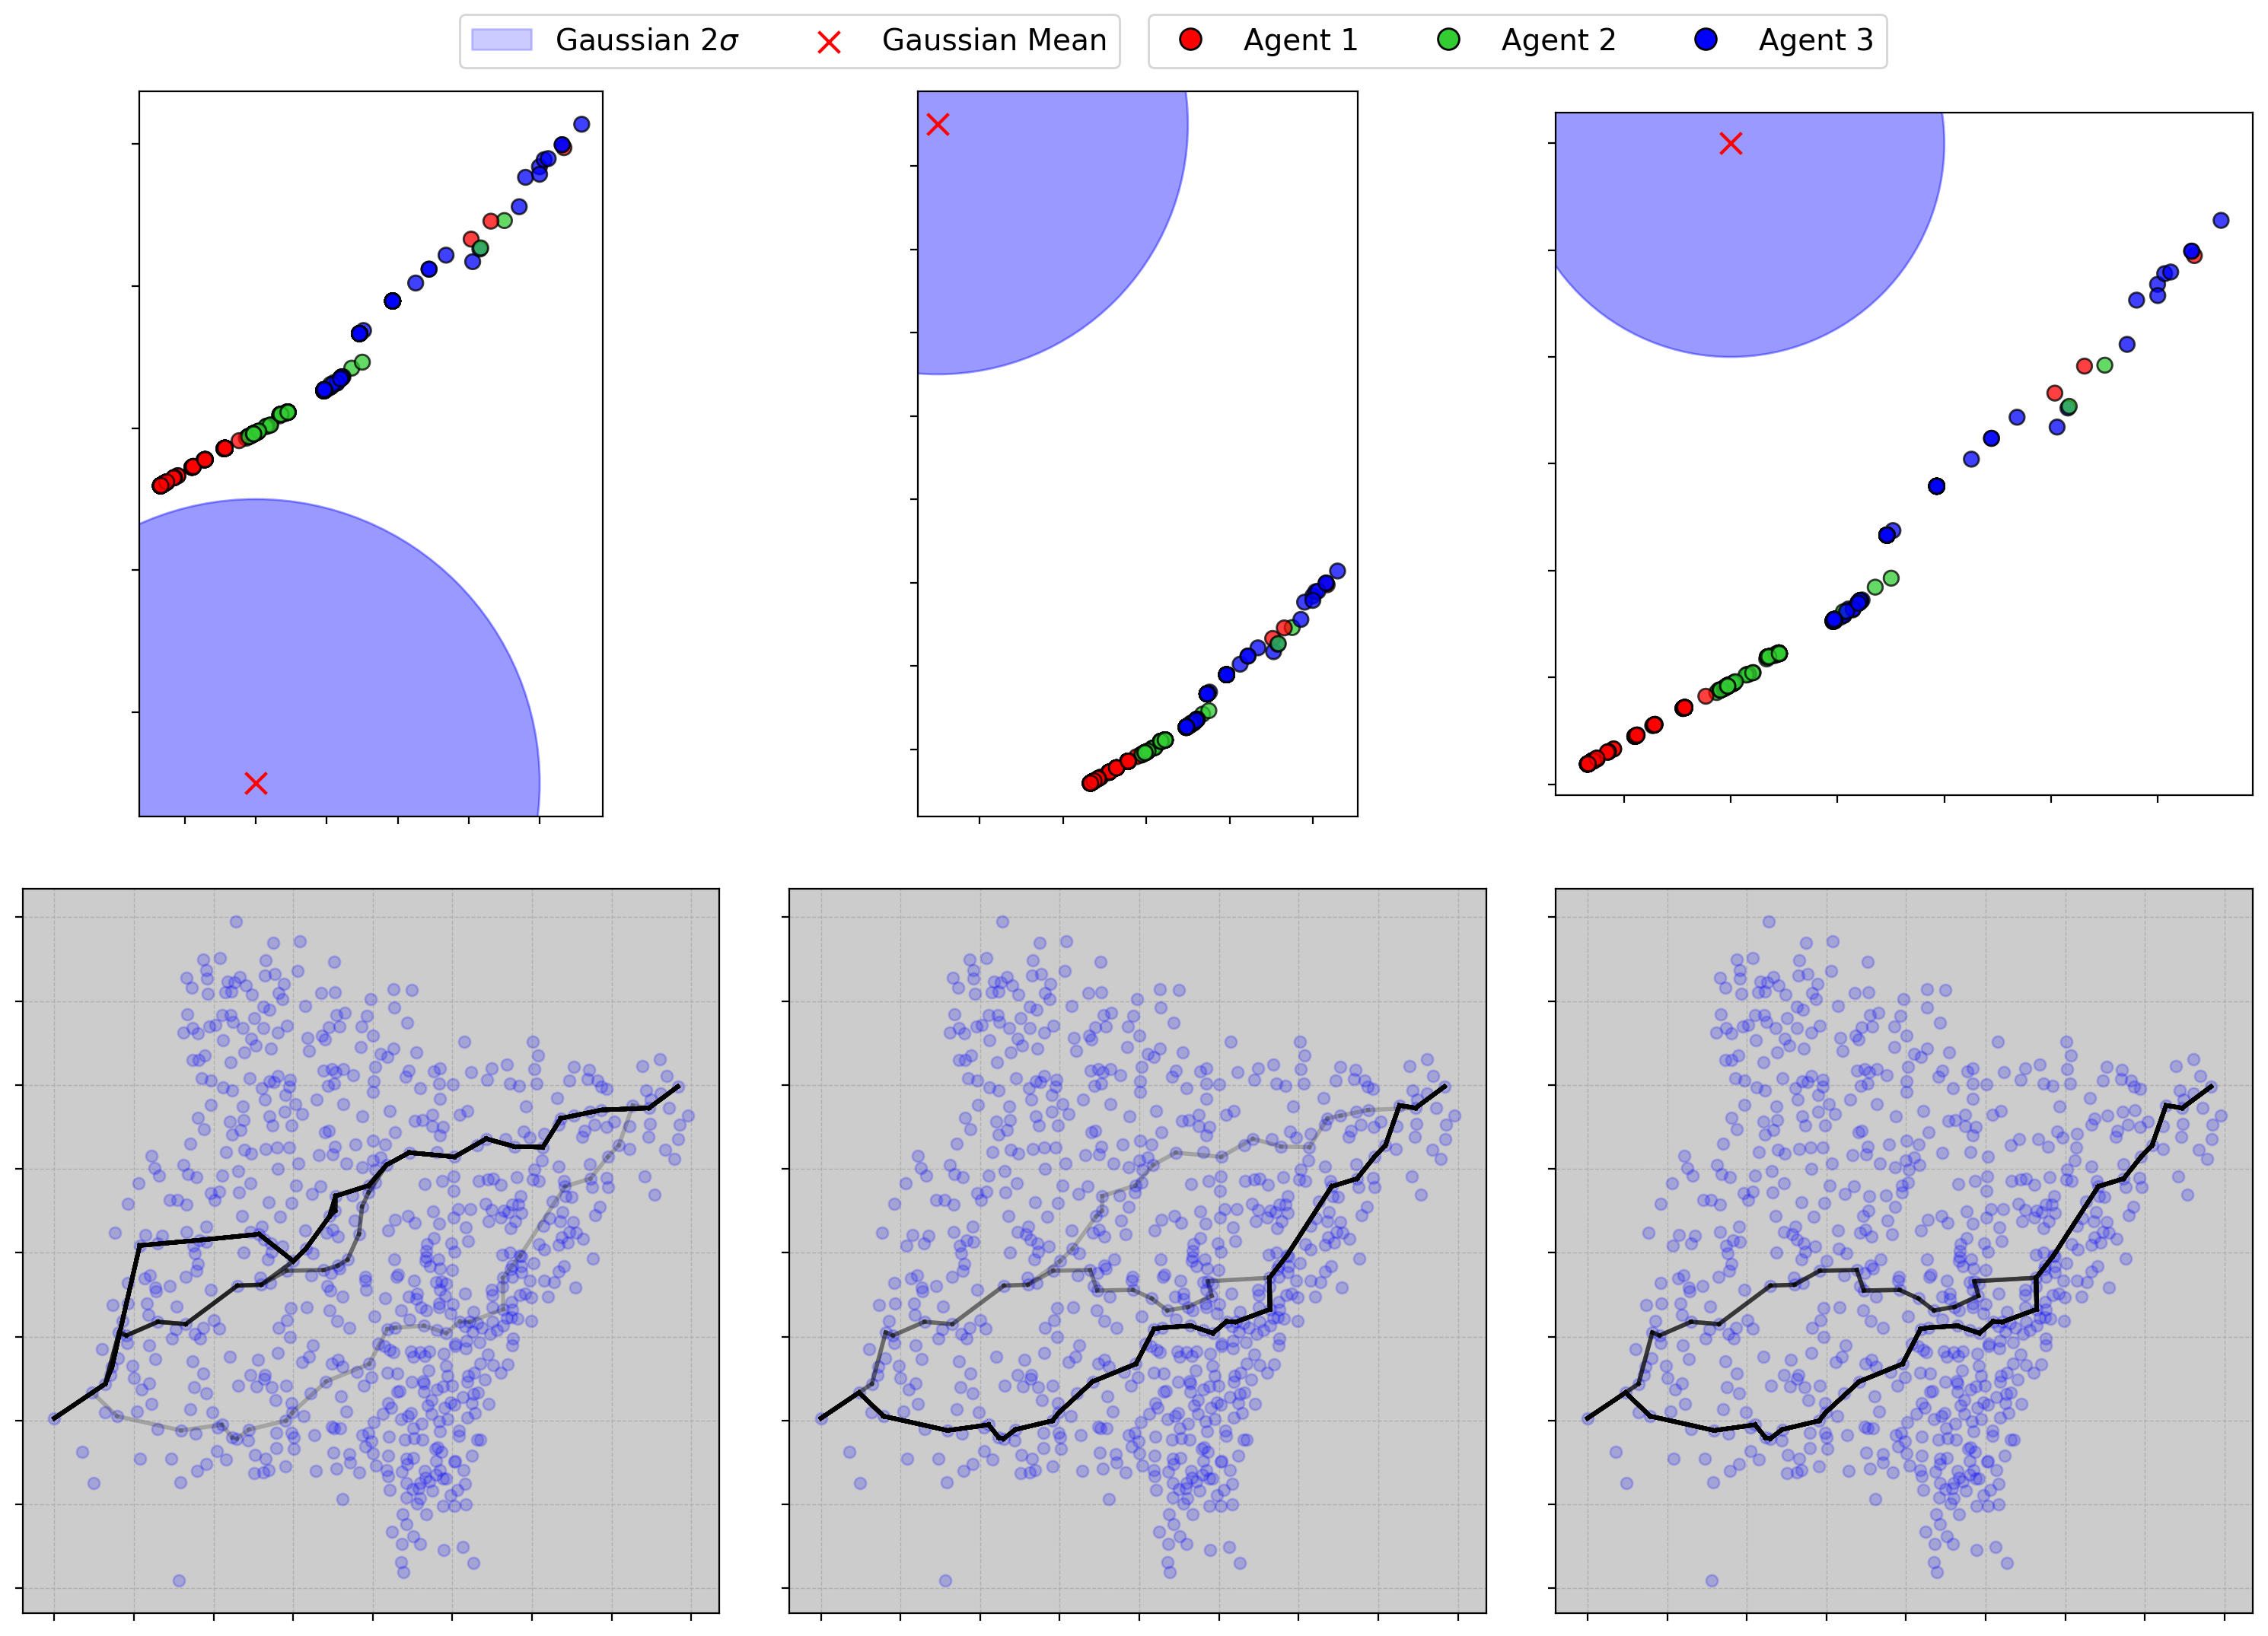

In [27]:
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to sample N points from a 2D Gaussian distribution
def sample_gaussian_2d(N, mean=(0, 0), sigma=1.0):
    x = np.random.randn(N, 2) * sigma  # Scale by sigma for both dimensions
    x += mean
    return x

N_test = 50
se_nodes_test = np.repeat(np.array([[124, 484]]), N_test, axis=0)

#gaussian_means = [(0, -0.5), (-0.5, 1.5), (0, 0.5), (0, 0.5), (0.7, 1.0)]
#gaussian_sigmas = [0.2, 0.3, 0.1, 0.4, 0.1]

gaussian_means = [(0, -0.5), (-0.5, 1.5), (0, 0.5)]
gaussian_sigmas = [0.2, 0.3, 0.1]

fig, axs = plt.subplots(2, 3, figsize=(15, 12), dpi=200)  # 2 rows, 4 columns

for i in range(len(gaussian_means)):
    gaussian_mean = gaussian_means[i]
    gaussian_sigma = gaussian_sigmas[i]
    
    x_gen_gaussian = sample_gaussian_2d(N_test, mean=gaussian_mean, sigma=gaussian_sigma)
    x_gen = torch.tensor(x_gen_gaussian, dtype=torch.float32)
    
    # Assuming these functions are defined: decoder, solver, latent_vectors, agents, z_mu, points, edges
    edges_gen, _, _ = decoder(x_gen)
    
    edges_gen = edges_gen.detach().numpy()
    path_gen = np.array(solver.batched_solver(edges_gen, se_nodes_test))
    
    # --- First plot: Latent space scatter plot ---
    ax = axs[0, i]  # Top row
    
    lats = z_mu[:, [0, 1]].detach()

    # Latent vectors and agent mapping
    lats = latent_vectors[-1]
    color_map = {1: 'red', 2: 'limegreen', 3: 'blue'}
    colors = np.array([color_map[agent] for agent in agents])
    
    # Scatter plot
    ax.scatter(lats[:, 0], lats[:, 1], c=colors, s=50, edgecolor='k', alpha=0.75)
    
    # Highlight the Gaussian with a circle
    gaussian_circle = plt.Circle(gaussian_mean, 2 * gaussian_sigma, color='blue', alpha=0.4, fill=True)
    ax.add_artist(gaussian_circle)
    
    # Plot the mean of the Gaussian
    ax.scatter([gaussian_mean[0]], [gaussian_mean[1]], color='red', marker='x', s=100)
    
    ax.tick_params(axis='both', which='major', labelsize=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal', 'box')

    # --- Second plot: Paths generated from the latent space ---
    ax = axs[1, i]  # Bottom row
    ax.set_facecolor((0, 0, 0, 0.2))
    ax.scatter(points[:, 0], points[:, 1], s=30, color='blue', alpha=0.2)
    
    ax.tick_params(axis='both', which='major', labelsize=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    for p in path_gen:
        ee = edges[np.argwhere(p > 0).squeeze()]
        for line in points[ee]:
            x_values = [line[0, 0], line[1, 0]]
            y_values = [line[0, 1], line[1, 1]]
            ax.plot(x_values, y_values, color='black', alpha=0.2, linewidth=2)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)


plt.tight_layout()

# Create the common legends outside the loop
# Common Gaussian legend
circle_legend = Circle((0, 0), 1, color='blue', alpha=0.2, label='Gaussian $2\sigma$')
cross_legend = plt.scatter([], [], color='red', marker='x', s=100, label='Gaussian Mean')
fig.legend([circle_legend, cross_legend], ['Gaussian $2\sigma$', 'Gaussian Mean'], fontsize=14, loc='upper right', bbox_to_anchor=(0.5, 0.90), ncol=2)

# Common Agents legend
legend_labels = {1: 'Agent 1', 2: 'Agent 2', 3: 'Agent 3'}
handles_agents = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10, markeredgecolor='k') 
                  for key in legend_labels.keys()]
fig.legend(handles_agents, [legend_labels[key] for key in legend_labels.keys()], fontsize=14, loc='upper left', bbox_to_anchor=(0.5, 0.90), ncol=3)

# Adjust layout further if needed
plt.subplots_adjust(top=0.85, wspace=0.1, hspace=0.1)

# Save the figure with tight bounding box
plt.savefig('./imgs_paper/combined_synthetic_small.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
#x_gen = z_mu[agent_indicator==3].mean(0).unsqueeze(0) #+ 0.01*torch.randn((1000,latent_dim))

In [112]:
compute_js_divergence(path_gen, true_paths[-1000:])

0.12737847997926247

In [115]:
vals = np.array([0.1273, 0.1359, 0.1311, 0.1246, 0.1274])

In [116]:
vals.mean()

0.12926

In [117]:
vals.std()

0.003911316913777246

In [40]:
path_gen.shape

(1000, 7230)

In [42]:
true_paths.shape

(6000, 7230)

In [19]:
x_gen = torch.tensor([[0., -0.5]]) + 0.15*torch.tensor([1,1])*torch.randn((1000,2))
edges_gen = (decoder(x_gen).detach().numpy())
path_gen = np.array(solver.batched_solver(edges_gen, se_nodes_test))

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

for p in path_gen:
    ee = edges[np.argwhere(p>0).squeeze()]
    for line in points[ee]:
        x_values = [line[0, 0], line[1, 0]]
        y_values = [line[0, 1], line[1, 1]]
    
        ax.plot(x_values, y_values, color='black', alpha=0.3, linewidth=3) 
ax.scatter(points[:,0], points[:,1], s=3)

IndexError: index 500 is out of bounds for axis 0 with size 500

In [ ]:
i = 0

In [ ]:
latent_vectors[-1,i]

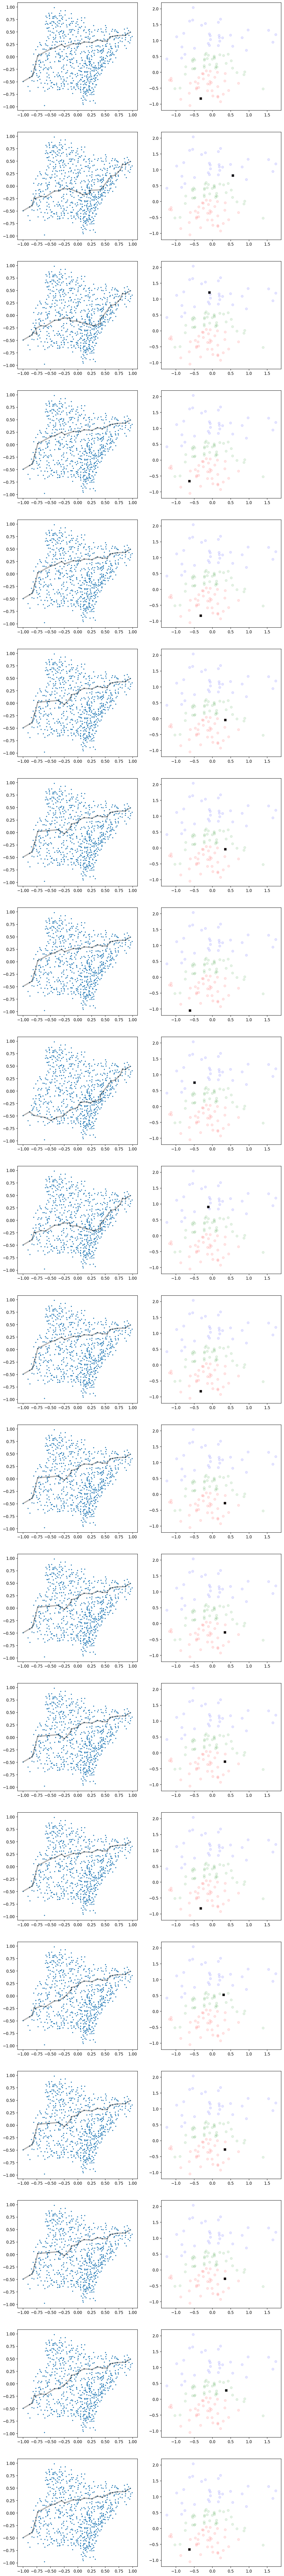

In [20]:
N_paths_vis = 20

fig, ax = plt.subplots(N_paths_vis, 2, figsize=(12, 6*N_paths_vis), dpi=150)

for i in range(N_paths_vis):
    
    lats_unique, indx_first = np.unique(latent_vectors[-1], axis=0, return_index=True)
    color_map = {1: 'red', 2: 'green', 3: 'blue'}
    colors = np.array([color_map[agent] for agent in agents[indx_first]])
    ax[i,1].scatter(lats_unique[:,0], lats_unique[:,1], c=colors, alpha=0.1)
    ax[i,1].scatter(latent_vectors[-1,i,0], latent_vectors[-1,i,1], alpha=1, color='black', marker='X')
    
    p = true_paths[N_train:][i]
    ee = edges[np.argwhere(p>0).squeeze()]
    for line in points[ee]:
        x_values = [line[0, 0], line[1, 0]]
        y_values = [line[0, 1], line[1, 1]]
        ax[i,0].plot(x_values, y_values, color='black', alpha=0.3, linewidth=3) 
    ax[i,0].scatter(points[:,0], points[:,1], s=3)

In [ ]:
lats_unique.shape

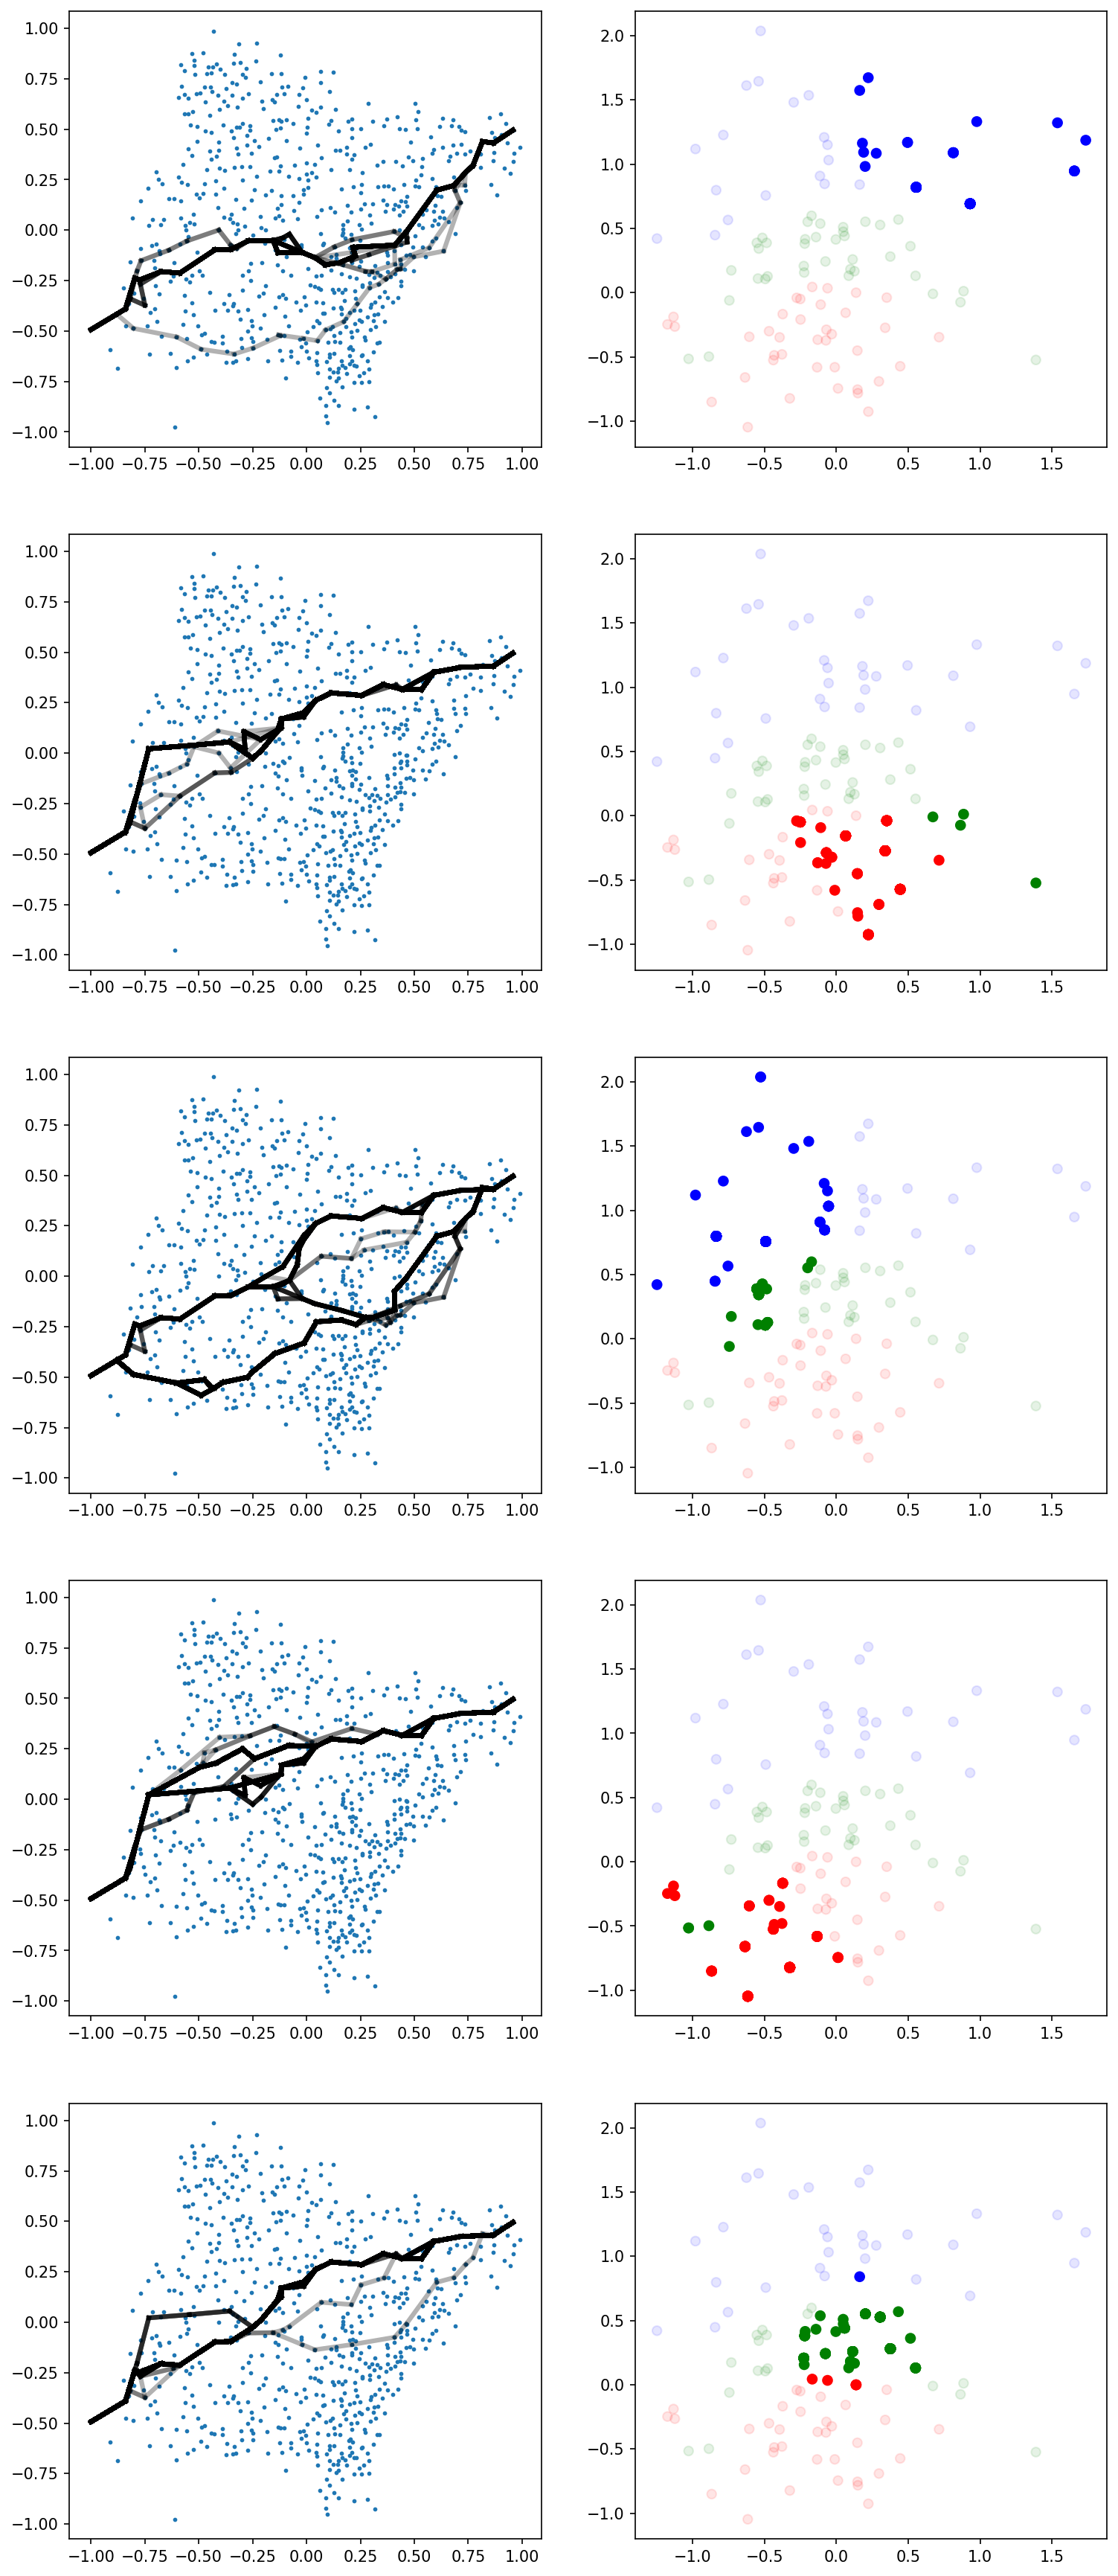

In [21]:
from sklearn.cluster import KMeans

n_of_clusters = 5

kmeans = KMeans(n_clusters=n_of_clusters, random_state=0).fit(latent_vectors[-1,:,:])
centroids = kmeans.cluster_centers_
clusters = kmeans.predict(latent_vectors[-1,:,:])

fig, ax = plt.subplots(n_of_clusters, 2, figsize=(12, 6*n_of_clusters), dpi=150)

for i in range(n_of_clusters):

    mask_clust = clusters==i
    lats_unique, indx_first = np.unique(latent_vectors[-1], axis=0, return_index=True)
    color_map = {1: 'red', 2: 'green', 3: 'blue'}
    colors_unique = np.array([color_map[agent] for agent in agents[indx_first]])
    colors = np.array([color_map[agent] for agent in agents])
    ax[i,1].scatter(lats_unique[:,0], lats_unique[:,1], c=colors_unique, alpha=0.1)
    ax[i,1].scatter(latent_vectors[-1,mask_clust,0], latent_vectors[-1,mask_clust,1], alpha=1, color=colors[mask_clust])
    
    paths = true_paths[N_train:][mask_clust]
    for p in paths:
        ee = edges[np.argwhere(p>0).squeeze()]
        for line in points[ee]:
            x_values = [line[0, 0], line[1, 0]]
            y_values = [line[0, 1], line[1, 1]]
            ax[i,0].plot(x_values, y_values, color='black', alpha=0.3, linewidth=3) 
    ax[i,0].scatter(points[:,0], points[:,1], s=3)

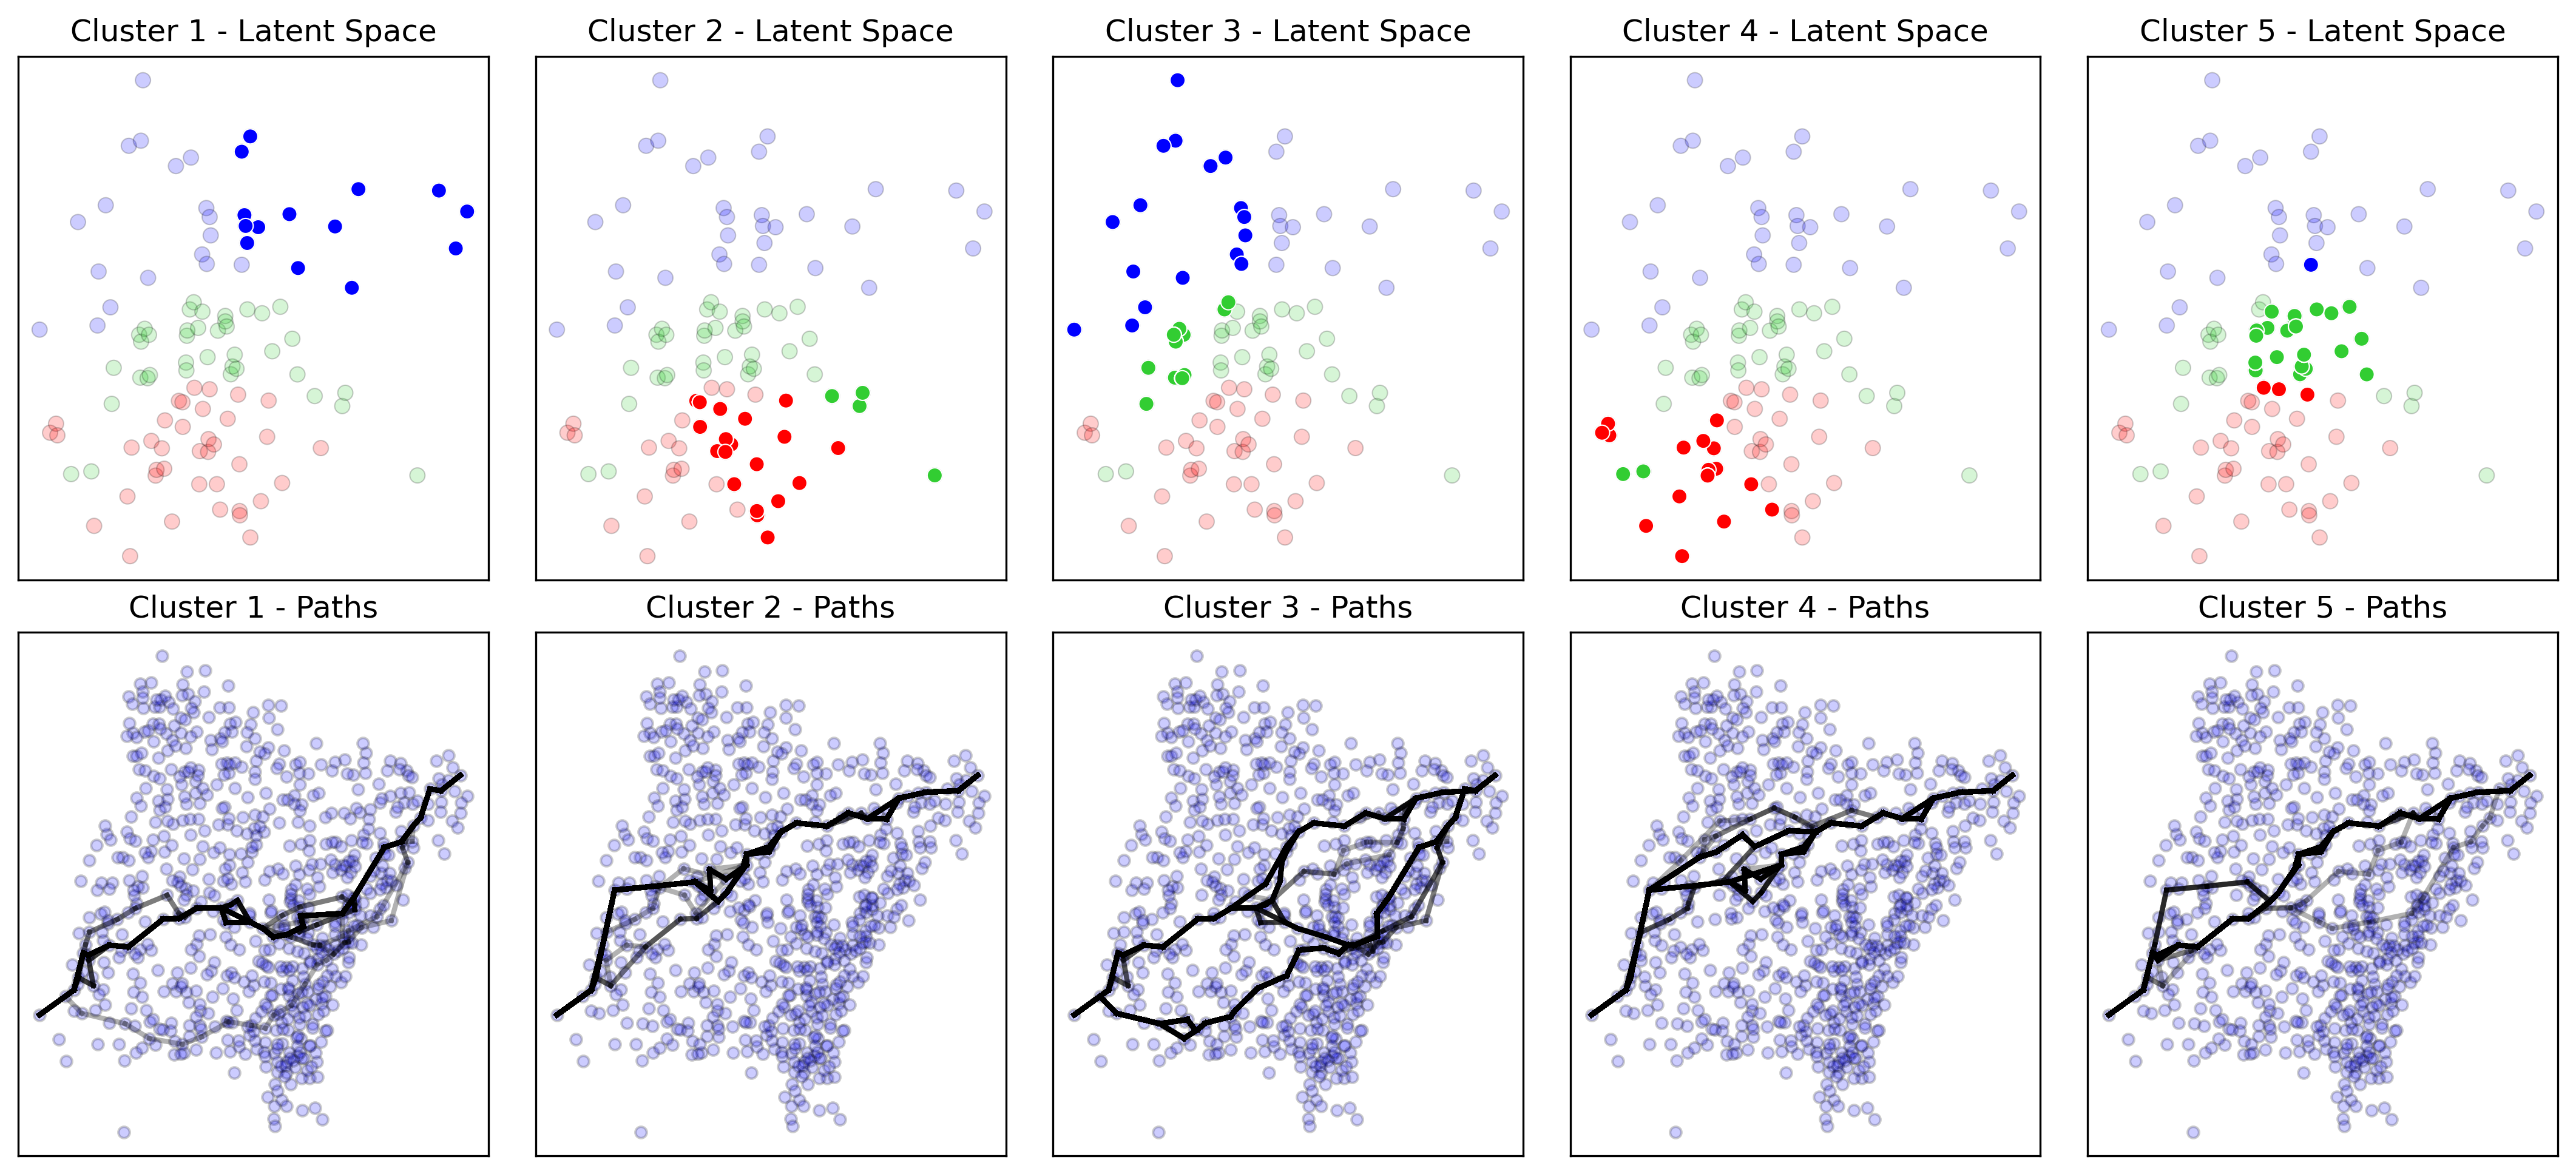

In [21]:
from sklearn.cluster import KMeans
# Set up clustering
n_of_clusters = 5
kmeans = KMeans(n_clusters=n_of_clusters, random_state=0).fit(latent_vectors[-1, :, :])
centroids = kmeans.cluster_centers_
clusters = kmeans.predict(latent_vectors[-1, :, :])

# Create the figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, n_of_clusters, figsize=(18, 8), dpi=300)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# Color map for agent classes
color_map = {1: 'red', 2: 'limegreen', 3: 'blue'}

for i in range(n_of_clusters):
    # Mask for the current cluster
    mask_clust = clusters == i
    
    # Unique latent vectors and their colors
    lats_unique, indx_first = np.unique(latent_vectors[-1], axis=0, return_index=True)
    colors_unique = np.array([color_map[agent] for agent in agents[indx_first]])
    colors = np.array([color_map[agent] for agent in agents])
    
    # Scatter plot for the latent space
    axes[0, i].scatter(lats_unique[:, 0], lats_unique[:, 1], c=colors_unique, alpha=0.2, edgecolors='k', linewidths=0.5)
    axes[0, i].scatter(latent_vectors[-1, mask_clust, 0], latent_vectors[-1, mask_clust, 1], c=colors[mask_clust], edgecolors='w', linewidths=0.5)
    axes[0, i].set_title(f'Cluster {i + 1} - Latent Space')
    axes[0, i].grid(True, linestyle='--', alpha=0.5)

    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

    # Path plots for the cluster
    axes[1, i].scatter(points[:, 0], points[:, 1], s=20, c='blue', marker='o', edgecolors='k', alpha=0.2)
    
    paths = true_paths[N_train:][mask_clust]
    for p in paths:
        ee = edges[np.argwhere(p > 0).squeeze()]
        for line in points[ee]:
            x_values = [line[0, 0], line[1, 0]]
            y_values = [line[0, 1], line[1, 1]]
            axes[1, i].plot(x_values, y_values, color='black', alpha=0.3, linewidth=2)
    
    axes[1, i].set_title(f'Cluster {i + 1} - Paths')
    axes[1, i].grid(True, linestyle='--', alpha=0.5)

# Save the final figure
plt.show()
fig.savefig('./imgs_paper/cluster_plots.png', format='png')

In [29]:
eps = 0.05
lr = '4e-05'
BS=250
alpha_kl = 0.005
seed_n = 0
latent_dim = 2
n_epochs=200

suffix = f'Perturbed_{eps}_{lr}_{BS}_{alpha_kl}_{seed_n}_{latent_dim}_{n_epochs}'

In [30]:
encoder = models.Encoder(input_size=n_edges + 4, output_size=latent_dim, hl_sizes=[1000, 1000])  
encoder.load_state_dict(torch.load(f'{model_path}encoder_{suffix}.pkl'))
encoder.eval()

decoder = models.ANN(input_size=latent_dim, output_size=n_edges, hl_sizes=[1000, 1000])  
decoder.load_state_dict(torch.load(f'{model_path}decoder_{suffix}.pkl'))
decoder.eval()

ANN(
  (act1): ReLU()
  (linear1): Linear(in_features=2, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=1000, bias=True)
  (linear3): Linear(in_features=1000, out_features=1000, bias=True)
  (linear3A): Linear(in_features=1000, out_features=1000, bias=True)
  (linear4): Linear(in_features=1000, out_features=7230, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [35]:
n_to_evals = 5
N_test = 1000
result_js = np.zeros((n_to_evals))
result_js_path = np.zeros((n_to_evals))
result_rank = np.zeros((n_to_evals))
for k in range(0,n_to_evals):
    edges_to_eval = decoder(torch.ones(N_test,2)).detach()
    edges_to_eval = (edges_to_eval + eps*torch.randn_like(edges_to_eval)).clip(0.0001)
    path_gen = np.array(solver.batched_solver(edges_to_eval.detach(), se_nodes_test))
    result_js[k] = compute_js_divergence(true_paths[-1000:], path_gen)
    result_js_path[k] = compute_js_divergence_paths(true_paths[-1000:].astype(int), path_gen)
    result_rank[k] = rank_comparison(true_paths[-1000:].astype(int), path_gen)

In [36]:
(result_js.mean(), result_js.std())

(0.05864460721591871, 0.004444708944202742)

In [37]:
(result_js_path.mean(), result_js_path.std())

(0.6713286713286712, 0.0886394095190282)

In [38]:
(result_rank.mean(), result_rank.std())

(0.8135839247753303, 0.02517174594028548)

In [107]:
path_gen

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [108]:
true_paths[-1000:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
compute_js_divergence_paths(true_paths[-1000:], path_gen)

0.8325546111576978

In [134]:
true_paths[-1000:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [135]:
path_gen

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])